In [1]:
%autosave 30
%pylab inline

import tensorflow as tf
%matplotlib inline
import numpy as np
from collections import deque
from os import listdir
import functools


import pylab
from tsne import bh_sne
from matplotlib import pyplot as plt
import pandas
import scipy
import numpy as np
import sklearn.manifold
import os
import gc
from time import gmtime, strftime
import seaborn as sns
from os import listdir
from os.path import isfile, join
import math
from scipy.stats.stats import pearsonr
import random as rand
import pyproj
import functools
import pickle
import random
%autosave 30

image_width = 128

def display(image, min = 0.0, max = 1.0):
    plt.imshow(image, cmap = plt.get_cmap('gray'), interpolation='nearest')
    plt.show()
    
    
def memoize(obj, maxlen = 2000):
    """A decorator to cache advice objects using the advice key"""
    cache = obj.cache = {}
    deck = obj.deck = deque([], maxlen = maxlen)

    @functools.wraps(obj)
    def memoizer(*args, **kwargs):
        key = args[0]
        if key not in cache:
            if len(deck) == deck.maxlen:
              del cache[deck.popleft()[0]]
            temp = obj(*args, **kwargs)
            cache[key] = temp
            deck.append((key, temp))
        return cache[key]
        
    return memoizer

@memoize
def load_mat_from_file(key):
    f = file("/home/isaac/Desktop/devika/ARCGIS/ArcGis/pickle_files/"+key+".npy","rb")
    return np.load(f)

@memoize
def get_file_containing(housex, housey):
#         print "house coords:", housex, housey
    for key in file_attributes:
        block = file_attributes[key]
    #         print block['xllcorner'], block['yllcorner']
        if block['xllcorner'] < housex < block['xllcorner'] + block['width']:
            if block['yllcorner'] < housey < block['yllcorner'] + block['height']:
                return key
    assert(1==0)

def imagex(housex, housey, block):
    return (int(housex)-block['xllcorner'])/5
def imagey(housex, housey, block):
    return (int(housey)-block['yllcorner'])/5



#housex and housey in meters
def get_heightmap_around(housex, housey, window_width_pixels = 28):
    
    def image_slice(key, housex, housey, radius = window_width_pixels/2):
        x = housex
        y = housey
        block = file_attributes[key]
        mat = load_mat_from_file(key)
        x1 = np.max([0,              imagex(x,y,block) - radius])
        x2 = np.min([block['ncols'], imagex(x,y,block) + radius])
        
        y1 = np.max([0,              imagey(x,y,block) - radius])
        y2 = np.min([block['nrows'], imagey(x,y,block) + radius])
        
        assert(x1 <= x2)
        assert(y1 <= y2)
        return  mat[block['nrows'] - y2:block['nrows'] - y1, x1:x2]
    
    window_width_feet = window_width_pixels * 5
    housex /= .3048 #convert to feet
    housey /= .3048
    x = housex
    y = housey
    ul = get_file_containing(x - window_width_feet/2, y - window_width_feet/2)
    ur = get_file_containing(x + window_width_feet/2, y - window_width_feet/2)
    ll = get_file_containing(x - window_width_feet/2, y + window_width_feet/2)
    lr = get_file_containing(x + window_width_feet/2, y + window_width_feet/2)

    for key in [ul, ur, ll, lr]:
        image = image_slice(key, x, y)
        if image.shape == (window_width_pixels, window_width_pixels):
            return image

    

    if ul == ur and lr == ll : # horizontal split


        result = np.zeros([window_width_pixels, window_width_pixels])
        upper_slice = image_slice(ul, housex, housey)
        lower_slice = image_slice(ll, housex, housey)
        
        result[:upper_slice.shape[0], :] = upper_slice
        result[ window_width_pixels - lower_slice.shape[0]:, :] = lower_slice


        return result
    elif ul == ll and ur == lr and ul != ur and ll != lr: # vertical split
        result = np.zeros([window_width_pixels, window_width_pixels])
        left_slice = image_slice(ll, housex, housey)
        right_slice = image_slice(ur, housex, housey)
  
        result[:, :left_slice.shape[1]] = left_slice
        result[:, window_width_pixels - right_slice.shape[1]:] = right_slice

        return result
    else: # four way split
        ll_slice = image_slice(ll, housex, housey)
        ul_slice = image_slice(ul, housex, housey)
        lr_slice = image_slice(lr, housex, housey)
        ur_slice = image_slice(ur, housex, housey)
        
        result = np.zeros([window_width_pixels, window_width_pixels])
        result[:ll_slice.shape[0], :ll_slice.shape[1]] = ll_slice
        result[:lr_slice.shape[0], window_width_pixels - lr_slice.shape[1]:] = lr_slice
        
        result[window_width_pixels - ul_slice.shape[0]:, :ul_slice.shape[1]] = ul_slice
        result[window_width_pixels - ur_slice.shape[0]:, window_width_pixels - ur_slice.shape[1]:] = ur_slice
        return result

        

def window_violated_chunk_borders(housex, housey):
    corners = [(housex-window_width_feet/2, housey-window_width_feet/2),
              (housex-window_width_feet/2, housey+window_width_feet/2),
              (housex+window_width_feet/2, housey+window_width_feet/2),
              (housex+window_width_feet/2, housey-window_width_feet/2)]
    files = map(lambda x: get_file_containing(x[0], x[1]), corners)
    return len(set(files)) > 1



file_attributes = {}

mypath = "/home/isaac/Desktop/devika/ARCGIS/ArcGis/ascii_files"
for filename in [f for f in listdir(mypath) if isfile(join(mypath, f))]: 
    attributes = {}
    with open(mypath + "/" + filename) as FileObj:
        for index, line in enumerate(FileObj):
            if(index < 6):
#                 print line
                attributes[line.split(" ")[0]] = int(line.split(" ")[-1][:-2])
            else:
                break # don't load the other lines into memory becuase that's a waste of time.

    attributes['width'] = attributes['ncols'] * attributes['cellsize']
    attributes['height'] = attributes['nrows'] * attributes['cellsize']
    file_attributes[filename] = attributes
print "loaded all file header attributes into dict"


def load_data(path, normalize_columns = False, only_columns_containing = ""):
    print("loading...")
    gc.collect() # collect garbage
    data = pandas.read_hdf(path, '/df')
    df = pandas.DataFrame(data)
    df = df.sort(['hcad']).fillna(0)
    df = df.reset_index()#(ascending=True)

    data_dict = {}
    for label in set(df._get_numeric_data().columns).union({'hcad'}):
        # union hcad to ensure that hcad col comes in even if not considered numerical
        if normalize_columns and  label != 'hcad':
            column_data = np.array(df[label].astype(float))
            column_data -= np.min(column_data)
            data_dict[label] = column_data / np.max(column_data)
        elif label != 'hcad':
            data_dict[label] = df[label].astype(float)

    result = pandas.DataFrame.from_dict(data_dict)

    result = result.replace([np.inf, -np.inf], 1)
    
    
    for label in result:
        if not only_columns_containing in str(label):
            result.drop([str(label)], axis = 1 , inplace= True)

    return result


wind_data = load_data("/home/isaac/Dropbox/data_for_brian/wind_features/hcad_interp_withoutpartial_rad100_hist8x8.mat.hd", 
              normalize_columns=True, only_columns_containing = "spd")
meta = pandas.read_csv("../data/df_meta.csv", low_memory = True, skiprows = 0, compact_ints=True)
meta = meta.sort(['hcad']).fillna(0)
meta = meta.reset_index()
y_data = load_data("/home/isaac/Dropbox/data_for_brian/y_df.hd")
hcad = load_data("/home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_point.hd", 
              normalize_columns=True)


# wind_data = wind_data[meta['img0'] == 1]
# y_data = wind_data[meta['img0'] == 1]
y_gaussian = pickle.load(open( "/home/isaac/Desktop/house_guassian_damage_balance.p", "rb" ) )

wgs84=pyproj.Proj("+init=EPSG:4326") # LatLon with WGS84 datum used by GPS units and Google Earth
UTM26N=pyproj.Proj("+init=EPSG:2278") # UTM coords, zone Texas Central, WGS84 datum



# metamat, extra_features, regression_y, cat_y = get_batch(1, random = False, start_index=12314)

# meta = load_data("/home/isaac/Dropbox/data_for_brian/meta/df_meta.hd")

# X, _, _ = get_batch(100)
# plt.imshow(X[0,:,:,0])
# plt.show()
# X = X[:,:,:,0].reshape([-1])
# print np.min(X)
# plt.hist(X, bins = 50)
# plt.show()
hcad = np.array(hcad)
wind_data = np.array(wind_data)


# convert hcad to nice log scale
for i in range(hcad.shape[1]):
    hcad[:,i] = log(hcad[:,i] + .001)
    hcad[:,i] -= np.min(hcad[:,i])
    hcad[:,i] /= np.max(hcad[:,i])

housewise_square_damage_actual = np.array(pickle.load( open( "../housewise_square_damage_actual.p", "rb" ) ))


image_width = 224

train_key_list = ['372W', '367U', '332T', '299J', '454A', '398Y', '336P', '459V', '532L', '617H', '455D', '462W', '528K', '375E', '458N', '376G', '447B', '412F', '456Z', '286M', '573R', '408L', '367X', '528M', '337Y', '453F', '367E', '501U', '285M', '418D', '406L', '371U', '580C', '337M', '502W', '537Z', '460T', '415X', '299W', '447H', '451V', '580Z', '298C', '375N', '411T', '330U', '613D', '289W', '494C', '367Z', '454S', '286N', '444Q', '495N', '419V', '542N', '527L', '376H', '380C', '457F', '333G', '571U', '414X', '284M', '534E', '496T', '336W', '375W', '407U', '336D', '458A', '331W', '336G', '407 ', '289L', '489Y', '367R', '489X', '419T', '290Y', '575V', '444K', '288D', '489B', '458U', '330A', '413U', '367Y', '290N', '618F', '370B', '328J', '249V', '576G', '292K', '449U', '417A', '446U', '528T', '328V', '331G', '495Z', '446A', '452M', '573L', '493V', '334V', '414S', '249U', '338F', '333T', '453Q', '455P', '617Y', '574K', '369J', '445Y', '538L', '530C', '293N', '620D', '333J', '530K', '456H', '539P', '537M', '334G', '459T', '492J', '491L', '452P', '259S', '575C', '528R', '452H', '370D', '534S', '485G', '412E', '378R', '299U', '576U', '451W', '376A', '458H', '491X', '537W', '533V', '497D', '408R', '457J', '331Q', '570A', '291J', '376C', '250W', '539Y', '446C', '537F', '333P', '338V', '527M', '289Z', '533H', '617B', '501C', '410G', '453T', '411Q', '336U', '571V', '414P', '534X', '415W', '616J', '330Z', '447C', '492C', '475V', '288P', '327M', '455M', '216Z', '578X', '371W', '286X', '333E', '419X', '377M', '542J', '375R', '501T', '485R', '408U', '331A', '325D', '578W', '496X', '488C', '460Z', '336S', '461P', '460C', '579F', '539R', '326X', '536F', '456T', '530U', '535J', '249Z', '576F', '451X', '493L', '404Y', '616A', '459Y', '489E', '335N', '580Q', '446R', '539U', '336J', '452N', '618V', '331T', '407Y', '493E', '534Y', '580S', '372R', '536U', '327Z', '415Y', '457X', '377X', '529N', '289D', '416R', '495P', '283J', '405X', '297X', '331B', '500S', '449B', '368N', '459E', '499A', '452B', '369S', '453J', '375S', '571A', '372A', '530Q', '419C', '370U', '453R', '292W', '376T', '487J', '657C', '334J', '326F', '530G', '419R', '407C', '407X', '411D', '326T', '534F', '328G', '530N', '296V', '411E', '369G', '369R', '657E', '332L', '379L', '538W', '336V', '412S', '528Z', '373N', '451B', '339N', '528U', '289X', '492F', '498M', '617M', '578D', '451N', '368K', '413B', '576C', '494B', '573Y', '407J', '249W', '419G', '528E', '337P', '415N', '290Z', '485M', '488S', '335T', '528P', '410W', '250J', '298J', '293W', '451C', '378T', '530T', '283E', '327E', '502J', '292Z', '291X', '456M', '411K', '250G', '336F', '414T', '367K', '577F', '497A', '290K', '370C', '491K', '372G', '449Z', '575X', '489R', '369D', '460D', '411P', '338Z', '501N', '452S', '573F', '327K', '4938', '324H', '250Z', '500D', '338W', '334R', '414C', '413H', '536N', '332Q', '372P', '489L', '461R', '575E', '419H', '490Q', '498F', '368M', '326Q', '415P', '573G', '495S', '334U', '290P', '502B', '338E', '444V', '496Q', '405Y', '498G', '370V', '616H', '444R', '410T', '538Z', '618Y', '248Y', '493A', '537H', '486K', '541L', '368F', '329R', '258V', '500Z', '446F', '369C', '419N', '618K', '535D', '488X', '446S', '577X', '291G', '259N', '299S', '494U', '416E', '376u', '410V', '535N', '414U', '445V', '575M', '419A', '615R', '489Z', '492B', '413Y', '488L', '488U', '575P', '618L', '418P', '529J', '619A', '336T', '448F', '457P', '375G', '572Q', '529B', '329E', '454B', '375V', '530Y', '420C', '447N', '420A', '411C', '371T', '530S', '250S', '409G', '297S', '492S', '498C', '373J', '575R', '371Q', '287E', '447E', '618J', '572X', '536M', '489T', '327J', '457B', '373R', '372K', '409S', '298N', '625V', '531D', '456R', '444G', '572T', '326U', '576Y', '529K', '331F', '415B', '496R', '323C', '368J', '580D', '452W', '448D', '494H', '327N', '449Y', '534C', '259W', '375H', '378L', '326J', '412V', '298M', '299X', '447D', '415J', '376B', '535U', '493T', '533Y', '575Z', '328D', '619R', '453X', '571Q', '453V', '494N', '445H', '572S', '258T', '540H', '490W', '576J', '371B', '366R', '537R', '533M', '328S', '490S', '414Y', '574U', '490G', '411L', '329X', '535L', '327U', '413Z', '485F', '417H', '461U', '412T', '410Z', '459Z', '453G', '290F', '377S', '534P', '493S', '576T', '571R', '338L', '458J', '339J', '286Y', '331J', '617S', '325B', '414A', '368A', '298V', '502N', '579C', '369Y', '457V', '367Q', '415T', '498E', '494M', '450S', '533Q', '571T', '337A', '536P', '287K', '293Y', '250E', '336C', '532M', '289E', '657D', '487E', '492A', '575B', '454Z', '489N', '530M', '455N', '412J', '488V', '450W', '411A', '372F', '417C', '458M', '529T', '327V', '292S', '531X', '536V', '411U', '407R', '502L', '496P', '367T', '327C', '371M', '407H', '368C', '490M', '532R', '485B', '290J', '495U', '324M', '415Q', '408K', '405Z', '449A', '530X', '577J', '446H', '373T', '616M', '327D', '490F', '366Q', '529F', '455Z', '486G', '577B', '492V', '446K', '495W', '290D', '455Y', '258X', '490B', '450H', '330R', '488B', '449X', '498D', '530A', '619D', '298P', '575Q', '450D', '337S', '657F', '501R', '371K', '413P', '370Q', '285X', '378M', '573J', '496G', '298G', '497N', '486M', '338S', '287T', '420G', '578U', '537G', '535K', '449G', '578B', '578J', '258Z', '611D', '409Q', '379X', '412U', '496H', '461S', '531V', '325M', '539W', '298B', '446P', '531N', '574H', '405S', '573U', '536Z', '536L', '496L', '417P', '411Y', '290T', '332V', '368T', '538P', '453A', '369X', '259X', '538M', '375T', '285F', '371S', '282Q', '406U', '337X', '488T', '338M', '327W', '373Q', '616L', '617E', '371E', '460G', '411X', '535Z', '339S', '494D', '377T', '297U', '537L', '410K', '328X', '367C', '459P', '575A', '535X', '286J', '373Z', '533C', '338T', '444X', '290E', '411W', '248X', '285P', '573N', '368P', '618N', '411B', '490X', '450E', '620F', '376M', '501V', '498H', '326H', '574B', '413X', '292Q', '454X', '444B', '530E', '616N', '531Q', '454R', '380M', '500A', '250K', '537E', '539S', '535F', '284V', '292U', '337R', '486S', '286G', '456S', '497B', '618C', '419U', '447W', '288Z', '531L', '377Z', '406D', '533X', '287G', '452C', '492T', '491A', '414V', '328N', '572', '619T', '500B', '528H', '571G', '529P', '451K', '569D', '373U', '289J', '414Z', '297R', '535V', '491U', '336L', '445S', '447L', '406V', '491E', '376D', '536S', '327H', '283V', '457Q', '490Y', '329Z', '532Z', '456L', '531T', '291E', '450Y', '328E', '371R', '375X', '486H', '657M', '367L', '575K', '292V', '616F', '375Q', '539V', '530V', '329P', '530P', '444M', '534J', '407L', '541B', '486T', '456U', '533L', '407B', '531E', '540W', '408F', '336H', '418H', '414H', '414Q', '620G', '326A', '376F', '338D', '458Y', '529R', '332D', '444U', '454K', '259T', '529G', '248W', '296R', '332A', '333C', '529Z', '297W', '529S', '491G', '326B', '459L', '417W', '376', '407D', '420Z', '577K', '448H', '493D', '325Q', '578C', '336K', '366K', '618X', '412Q', '454P', '462X', '500F', '578H', '330Y', '531W', '500E', '490J', '329K', '575U', '289H', '371X', '368W', '534N', '536E', '538U', '528C', '410E', '287P', '496B', '371H', '378P', '534T', '291Z', '407P', '338G', '570F', '489D', '571L', '502P', '532B', '495H', '490V', '418S', '493K', '485C', '380V', '248U', '413E', '488F', '408J', '288R', '421J', '413R', '579G', '291T', '332E', '412B', '458V', '490P', '414R', '325V', '332J', '571B', '621A', '330D', '572Z', '499G', '529L', '377E', '286U', '572G', '533P', '537J', '618D', '327X', '414L', '527H', '330T', '657H', '539X', '290V', '410U', '292X', '496K', '488D', '336B', '457L', '414B', '412M', '287M', '569C', '327T', '450X', '491B', '540Z', '613C', '459S', '447P', '330W', '370T', '420N', '445Q', '532J', '332G', '616G', '380G', '573M', '369E', '292B', '496S', '413K', '329C', '532S', '574E', '457D', '619S', '495J', '293T', '527G', '570H', '491W', '407V', '445W', '290G', '372E', '486D', '293P', '415A', '328B', '501P', '378N', '291S', '415H', '491R', '379T', '446J', '489G', '571D', '250R', '368E', '282V', '493Z', '335V', '288N', '458S', '501W', '454C', '538Q', '333M', '455E', '328F', '292N', '453Z', '446X', '452X', '501Z', '531G', '456A', '450P', '408G', '616D', '541C', '531S', '377Q', '339T', '616C', '370A', '406P', '534M', '458Z', '451Y', '451Q', '331P', '297L', '538K', '451G', '286H', '409K', '450Z', '580U', '293Z', '417T', '488W', '418E', '539N', '329D', '569H', '410A', '330M', '368G', '412Z', '297N', '338H', '540 ', '578F', '536T', '449T', '487B', '329S', '288B', '368V', '533F', '580L', '337Z', '286R', '494X', '490Z', '334Q', '376E', '286L', '450J', '410H', '456D', '298L', '330S', '409H', '333A', '415M', '618Q', '454M', '493R', '530L', '407E', '490U', '297V', '413G', '250F', '489Q', '330G', '410L', '572J', '6160', '501L', '502E', '497M', '502C', '414W', '366H', '406R', '372X', '331X', '367D', '330B', '367A', '414G', '495L', '459M', '412X', '459K', '381W', '488H', '535E', '618U', '448E', '619P', '450U', '371F', '490A', '367G', '578G', '374M', '570E', '371N', '332N', '368Z', '617U', '535Y', '462S', '571Z', '375K', '537P', '495K', '618T', '413W', '573C', '453 ', '337L', '290M', '324D', '379N', '249Y', '455V', '455Q', '289A', '413T', '578T', '298W', '485E', '373A', '657G', '285K', '333D', '454W', '290X', '658C', '540X', '285T', '250Y', '380P', '258Y', '532K', '420J', '329W', '446Y', '532X', '338Q', '377B', '533E', '325E', '533G', '493Y', '617R', '453S', '542T', '366V', '494P', '501F', '410P', '618B', '337D', '368L', '571F', '500H', '3335', '620K', '576W', '297P', '489W', '420P', '286W', '498A', '535Q', '418R', '538X', '299N', '458B', '292R', '372H', '451J', '249S', '530W', '537Y', '496F', '460V', '446E', '532N', '535C', '446Z', '333S', '535T', '335S', '334M', '620E', '415S', '455G', '492R', '378B', '617X', '339A', '298Y', '331S', '7753', '298Z', '575H', '571N', '334E', '529H', '456F', '326S', '335Z', '457G', '495A', '409W', '456X', '369T', '332U', '450T', '455L', '417B', '495M', '529W', '495T', '530H', '454H', '491J', '372Z', '419L', '618Z', '413A', '452D', '420Q', '541E', '487A', '283K', '339W', '288U', '337W', '282U', '446Q', '499B', '286Z', '325R', '535P', '407S', '327Y', '461G', '411R', '538N', '329A', '335U', '501D', '330C', '487Y', '577C', '501S', '445T', '539Q', '418W', '373P', '407K', '457C', '287H', '489F', '445M', '577D', '618H', '411Z', '531R', '490H', '455F', '296U', '328Q', '406Y', '451F', '420E', '492U', '338U', '454T', '371V', '576S', '579A', '409C', '408N', '529X', '410F', '534B', '336A', '541M', '289V', '419D', '333H', '408T', '617V', '336E', '411J', '408X', '528G', '289T', '500P', '288K', '577L', '444Y', '380R', '460R', '414F', '501B', '291M', '528D', '453W', '411M', '492N', '329M', '531U', '330L', '578E', '486P', '454N', '337T', '500M', '331L', '370H', '374V', '537X', '378Q', '485L', '325C', '579B', '408Q', '380Q', '371J', '576K', '618P', '379Q', '577G', '283R', '541D', '337C', '369H', '618G', '538T', '446W', '415L', '418X', '490L', '298T', '288C', '380H', '535A', '288X', '452F', '292L', '577S', '454E', '369V', '489J', '493J', '490C', '287F', '336Q', '331N', '455C', '619C', '541W', '532D', '536H', '492H', '458W', '287N', '259P', '459W', '486R', '368B', '570B', '491F', '412R', '456G', '324N', '455B', '487Z', '338A', '369F', '329U', '369Q', '502F', '298U', '452J', '489K', '532Q', '289F', '497J', '488Q', '531J', '378A', '533Z', '330P', '578S', '420W', '456K', '447A', '335Q', '485A', '449Q', '574', '376K', '332C', '542S', '460H', '619M', '461H', '452K', '445N', '574C', '451A', '409R', '455H', '577A', '330X', '528B', '492W', '366D', '616P', '569B', '456J', '533B', '539Z', '292T', '373F', '454L', '489P', '328C', '452Z', '289K', '501E', '409Z', '371Z', '338Y', '323G', '419Z', '372B', '540T', '298K', '411F', '497G', '379A', '501J', '502G', '330V', '500C', '409L', '4559', '381J', '288G', '541A', '570L', '494Q', '494K', '528N', '410D', '576Q', '372S', '367V', '326Y', '494R', '406K', '338N', '370L', '337E', '528L', '291A', '404V', '573V', '537U', '330F', '489M', '298H', '411S', '332K', '452R', '377J', '287D', '4525', '337B', '450C', '617T', '572P', '457N', '407Q', '529Q', '496E', '489A', '450B', '574D', '571M', '530Z', '417X', '332F', '368Y', '495E', '498B', '573H', '450M', '531A', '459J', '498J', '289Q', '533T', '575N', '530F', '331U', '290Q', '329J', '486E', '501G', '331K', '286E', '497C', '296Y', '337F', '329Q', '288A', '420K', '490E', '413V', '290H', '501H', '450R', '494E', '494S', '452Y', '492X', '298R', '297Z', '577M', '329H', '289G', '368U', '367M', '328U', '445B', '577H', '292Y', '298Q', '292G', '370N', '331E', '414E', '527C', '491S', '372J', '497E', '494Y', '532G', '330K', '461A', '458X', '460N', '328T', '369W', '454Y', '418Q', '325J', '420M', '619Q', '366M', '448A', '494L', '288M', '580B', '490D', '289R', '370R', '373K', '250L', '409U', '298X', '283Q', '450V', '411V', '333K', '375L', '576N', '573', '407N', '327L', '291U', '326R', '453U', '492Z', '412A', '486A', '535W', '376U', '452V', '329G', '327R', '576H', '620H', '412D', '456B', '460W', '578A', '291P', '332P', '298E', '249X', '491T', '537T', '445R', '287R', '538Y', '573Q', '460Y', '409B', '410B', '460Q', '454U', '380D', '327P', '618A', '570C', '579E', '250X', '531M', '420S', '452T', '536X', '618S', '336Z', '494W', '286V', '338C', '455X', '488A', '445U', '367P', '292C', '288S', '493H', '490N', '289C', '327B', '445Z', '444F', '371G', '379S', '573Z', '531F', '458C', '494A', '370E', '493M', '337H', '573D', '332B', '370Z', '494Z', '289B', '326V', '410N', '496N', '491V', '450Q', '328Z', '534L', '618E', '416Z', '490R', '282Z', '377W', '534D', '378C', '335P', '372Q', '499D', '488G', '451L', '542A', '572V', '332S', '328M', '535R', '372D', '329N', '334A', '529A', '419F', '452G', '532P', '448Y', '331C', '459F', '534A', '457E', '378D', '290C', '334F', '451D', '375C', '493G', '449M', '575S', '494J', '407W', '446B', '413J', '417R', '571E', '459G', '331M', '461T', '461N', '528A', '448B', '571C', '450L', '539T', '453P', '575T', '250N', '455T', '379E', '331H', '299T', '454D', '536R', '420H', '572E', '372N', '578Z', '408P', '537Q', '529M', '457Z', '447J', '502A', '460X', '409T', '495V', '369L', '575G', '527D', '370M', '411G', '617W', '494G', '409A', '527B', '451E', '657A', '453Y', '375D', '620P', '570M', '375P', '334B', '328H', '5721', '374W', '450N', '616B', '370G', '576P', '289M', '416W', '488Z', '445P', '408S', '532H', '528F', '380L', '500G', '496J', '369M', '291W', '570G', '451M', '573X', '332H', '288F', '454G', '453D', '377F', '328W', '573K', '447S', '408A', '500R', '407Z', '453E', '461W', '369A', '412W', '457A', '619G', '291R', '491Y', '531K', '454F', '501A', '491P', '534H', '533U', '462T', '371D', '288L', '407F', '536K', '493X', '540Y', '415R', '444L', '495F', '459R', '375Z', '335J', '419Q', '460S', '492L', '453C', '368R', '531Y', '532W', '460F', '486F', '452Q', '490T', '337G', '491M', '375F', '500K', '330Q', '414M', '451U', '570D', '331V', '501X', '332M', '485D', '533N', '287V', '488J', '449L', '528Q', '291V', '373V', '532E', '407T', '332W', '536J', '447T', '258U', '375Y', '326P', '615M', '446V', '538V', '370Y', '377C', '337K', '445X', '446N', '492Y', '373W', '536Q', ' ', '493F', '500T', '461X', '489V', '450G', '491Q', '412H', '447G', '459H', '497H', '571K', '453H', '571P', '328P', '533J', '288H', '457T', '496C', '489U', '297Q', '657L', '449R', '408W', '299K', '286T', '572U', '580G', '497K', '538G', '575D', '488E', '452L', '330E', '299P', '377A', '250V', '408D', '571S', '486J', '333Q', '373C', '576V', '453L', '248V', '289Y', '408E', '329T', '327A', '374Z', '419S', '576B', '657B', '330J', '535H', '570K', '453N', '573T', '497F', '453K', '298F', '532Y', '460M', '455K', '533A', '329B', '486L', '576L', '369K', '488M', '455A', '334L', '620Q', '286F', '493C', '533R', '415E', '459X', '298S', '371P', '288Y', '620N', '457U', '406T', '492D', '368H', '531P', '289P', '454V', '416L', '534V', '576D', '502T', '616E', '574J', '408V', '618M', '374R', '290B', '416Q', '369Z', '248Z', '337N', '408Y', '413F', '370S']
random.seed(123)
random.shuffle(train_key_list)
val_key_list = train_key_list[:int(len(train_key_list) * .2)]

val_key_set = set(val_key_list)

train_key_set = set(train_key_list)

train_key_set = train_key_set - val_key_set

train_keymaps = ['372W', '367U', '332T', '299J', '454A', '398Y', '336P', '459V', '532L', '617H', '455D', '462W', '528K', '375E', '458N', '376G', '447B', '412F', '456Z', '286M', '573R', '408L', '367X', '528M', '337Y', '453F', '367E', '501U', '285M', '418D', '406L', '371U', '580C', '337M', '502W', '537Z', '460T', '415X', '299W', '447H', '451V', '580Z', '298C', '375N', '411T', '330U', '613D', '289W', '494C', '367Z', '454S', '286N', '444Q', '495N', '419V', '542N', '527L', '376H', '380C', '457F', '333G', '571U', '414X', '284M', '534E', '496T', '336W', '375W', '407U', '336D', '458A', '331W', '336G', '407 ', '289L', '489Y', '367R', '489X', '419T', '290Y', '575V', '444K', '288D', '489B', '458U', '330A', '413U', '367Y', '290N', '618F', '370B', '328J', '249V', '576G', '292K', '449U', '417A', '446U', '528T', '328V', '331G', '495Z', '446A', '452M', '573L', '493V', '334V', '414S', '249U', '338F', '333T', '453Q', '455P', '617Y', '574K', '369J', '445Y', '538L', '530C', '293N', '620D', '333J', '530K', '456H', '539P', '537M', '334G', '459T', '492J', '491L', '452P', '259S', '575C', '528R', '452H', '370D', '534S', '485G', '412E', '378R', '299U', '576U', '451W', '376A', '458H', '491X', '537W', '533V', '497D', '408R', '457J', '331Q', '570A', '291J', '376C', '250W', '539Y', '446C', '537F', '333P', '338V', '527M', '289Z', '533H', '617B', '501C', '410G', '453T', '411Q', '336U', '571V', '414P', '534X', '415W', '616J', '330Z', '447C', '492C', '475V', '288P', '327M', '455M', '216Z', '578X', '371W', '286X', '333E', '419X', '377M', '542J', '375R', '501T', '485R', '408U', '331A', '325D', '578W', '496X', '488C', '460Z', '336S', '461P', '460C', '579F', '539R', '326X', '536F', '456T', '530U', '535J', '249Z', '576F', '451X', '493L', '404Y', '616A', '459Y', '489E', '335N', '580Q', '446R', '539U', '336J', '452N', '618V', '331T', '407Y', '493E', '534Y', '580S', '372R', '536U', '327Z', '415Y', '457X', '377X', '529N', '289D', '416R', '495P', '283J', '405X', '297X', '331B', '500S', '449B', '368N', '459E', '499A', '452B', '369S', '453J', '375S', '571A', '372A', '530Q', '419C', '370U', '453R', '292W', '376T', '487J', '657C', '334J', '326F', '530G', '419R', '407C', '407X', '411D', '326T', '534F', '328G', '530N', '296V', '411E', '369G', '369R', '657E', '332L', '379L', '538W', '336V', '412S', '528Z', '373N', '451B', '339N', '528U', '289X', '492F', '498M', '617M', '578D', '451N', '368K', '413B', '576C', '494B', '573Y', '407J', '249W', '419G', '528E', '337P', '415N', '290Z', '485M', '488S', '335T', '528P', '410W', '250J', '298J', '293W', '451C', '378T', '530T', '283E', '327E', '502J', '292Z', '291X', '456M', '411K', '250G', '336F', '414T', '367K', '577F', '497A', '290K', '370C', '491K', '372G', '449Z', '575X', '489R', '369D', '460D', '411P', '338Z', '501N', '452S', '573F', '327K', '4938', '324H', '250Z', '500D', '338W', '334R', '414C', '413H', '536N', '332Q', '372P', '489L', '461R', '575E', '419H', '490Q', '498F', '368M', '326Q', '415P', '573G', '495S', '334U', '290P', '502B', '338E', '444V', '496Q', '405Y', '498G', '370V', '616H', '444R', '410T', '538Z', '618Y', '248Y', '493A', '537H', '486K', '541L', '368F', '329R', '258V', '500Z', '446F', '369C', '419N', '618K', '535D', '488X', '446S', '577X', '291G', '259N', '299S', '494U', '416E', '376u', '410V', '535N', '414U', '445V', '575M', '419A', '615R', '489Z', '492B', '413Y', '488L', '488U', '575P', '618L', '418P', '529J', '619A', '336T', '448F', '457P', '375G', '572Q', '529B', '329E', '454B', '375V', '530Y', '420C', '447N', '420A', '411C', '371T', '530S', '250S', '409G', '297S', '492S', '498C', '373J', '575R', '371Q', '287E', '447E', '618J', '572X', '536M', '489T', '327J', '457B', '373R', '372K', '409S', '298N', '625V', '531D', '456R', '444G', '572T', '326U', '576Y', '529K', '331F', '415B', '496R', '323C', '368J', '580D', '452W', '448D', '494H', '327N', '449Y', '534C', '259W', '375H', '378L', '326J', '412V', '298M', '299X', '447D', '415J', '376B', '535U', '493T', '533Y', '575Z', '328D', '619R', '453X', '571Q', '453V', '494N', '445H', '572S', '258T', '540H', '490W', '576J', '371B', '366R', '537R', '533M', '328S', '490S', '414Y', '574U', '490G', '411L', '329X', '535L', '327U', '413Z', '485F', '417H', '461U', '412T', '410Z', '459Z', '453G', '290F', '377S', '534P', '493S', '576T', '571R', '338L', '458J', '339J', '286Y', '331J', '617S', '325B', '414A', '368A', '298V', '502N', '579C', '369Y', '457V', '367Q', '415T', '498E', '494M', '450S', '533Q', '571T', '337A', '536P', '287K', '293Y', '250E', '336C', '532M', '289E', '657D', '487E', '492A', '575B', '454Z', '489N', '530M', '455N', '412J', '488V', '450W', '411A', '372F', '417C', '458M', '529T', '327V', '292S', '531X', '536V', '411U', '407R', '502L', '496P', '367T', '327C', '371M', '407H', '368C', '490M', '532R', '485B', '290J', '495U', '324M', '415Q', '408K', '405Z', '449A', '530X', '577J', '446H', '373T', '616M', '327D', '490F', '366Q', '529F', '455Z', '486G', '577B', '492V', '446K', '495W', '290D', '455Y', '258X', '490B', '450H', '330R', '488B', '449X', '498D', '530A', '619D', '298P', '575Q', '450D', '337S', '657F', '501R', '371K', '413P', '370Q', '285X', '378M', '573J', '496G', '298G', '497N', '486M', '338S', '287T', '420G', '578U', '537G', '535K', '449G', '578B', '578J', '258Z', '611D', '409Q', '379X', '412U', '496H', '461S', '531V', '325M', '539W', '298B', '446P', '531N', '574H', '405S', '573U', '536Z', '536L', '496L', '417P', '411Y', '290T', '332V', '368T', '538P', '453A', '369X', '259X', '538M', '375T', '285F', '371S', '282Q', '406U', '337X', '488T', '338M', '327W', '373Q', '616L', '617E', '371E', '460G', '411X', '535Z', '339S', '494D', '377T', '297U', '537L', '410K', '328X', '367C', '459P', '575A', '535X', '286J', '373Z', '533C', '338T', '444X', '290E', '411W', '248X', '285P', '573N', '368P', '618N', '411B', '490X', '450E', '620F', '376M', '501V', '498H', '326H', '574B', '413X', '292Q', '454X', '444B', '530E', '616N', '531Q', '454R', '380M', '500A', '250K', '537E', '539S', '535F', '284V', '292U', '337R', '486S', '286G', '456S', '497B', '618C', '419U', '447W', '288Z', '531L', '377Z', '406D', '533X', '287G', '452C', '492T', '491A', '414V', '328N', '572', '619T', '500B', '528H', '571G', '529P', '451K', '569D', '373U', '289J', '414Z', '297R', '535V', '491U', '336L', '445S', '447L', '406V', '491E', '376D', '536S', '327H', '283V', '457Q', '490Y', '329Z', '532Z', '456L', '531T', '291E', '450Y', '328E', '371R', '375X', '486H', '657M', '367L', '575K', '292V', '616F', '375Q', '539V', '530V', '329P', '530P', '444M', '534J', '407L', '541B', '486T', '456U', '533L', '407B', '531E', '540W', '408F', '336H', '418H', '414H', '414Q', '620G', '326A', '376F', '338D', '458Y', '529R', '332D', '444U', '454K', '259T', '529G', '248W', '296R', '332A', '333C', '529Z', '297W', '529S', '491G', '326B', '459L', '417W', '376', '407D', '420Z', '577K', '448H', '493D', '325Q', '578C', '336K', '366K', '618X', '412Q', '454P', '462X', '500F', '578H', '330Y', '531W', '500E', '490J', '329K', '575U', '289H', '371X', '368W', '534N', '536E', '538U', '528C', '410E', '287P', '496B', '371H', '378P', '534T', '291Z', '407P', '338G', '570F', '489D', '571L', '502P', '532B', '495H', '490V', '418S', '493K', '485C', '380V', '248U', '413E', '488F', '408J', '288R', '421J', '413R', '579G', '291T', '332E', '412B', '458V', '490P', '414R', '325V', '332J', '571B', '621A', '330D', '572Z', '499G', '529L', '377E', '286U', '572G', '533P', '537J', '618D', '327X', '414L', '527H', '330T', '657H', '539X', '290V', '410U', '292X', '496K', '488D', '336B', '457L', '414B', '412M', '287M', '569C', '327T', '450X', '491B', '540Z', '613C', '459S', '447P', '330W', '370T', '420N', '445Q', '532J', '332G', '616G', '380G', '573M', '369E', '292B', '496S', '413K', '329C', '532S', '574E', '457D', '619S', '495J', '293T', '527G', '570H', '491W', '407V', '445W', '290G', '372E', '486D', '293P', '415A', '328B', '501P', '378N', '291S', '415H', '491R', '379T', '446J', '489G', '571D', '250R', '368E', '282V', '493Z', '335V', '288N', '458S', '501W', '454C', '538Q', '333M', '455E', '328F', '292N', '453Z', '446X', '452X', '501Z', '531G', '456A', '450P', '408G', '616D', '541C', '531S', '377Q', '339T', '616C', '370A', '406P', '534M', '458Z', '451Y', '451Q', '331P', '297L', '538K', '451G', '286H', '409K', '450Z', '580U', '293Z', '417T', '488W', '418E', '539N', '329D', '569H', '410A', '330M', '368G', '412Z', '297N', '338H', '540 ', '578F', '536T', '449T', '487B', '329S', '288B', '368V', '533F', '580L', '337Z', '286R', '494X', '490Z', '334Q', '376E', '286L', '450J', '410H', '456D', '298L', '330S', '409H', '333A', '415M', '618Q', '454M', '493R', '530L', '407E', '490U', '297V', '413G', '250F', '489Q', '330G', '410L', '572J', '6160', '501L', '502E', '497M', '502C', '414W', '366H', '406R', '372X', '331X', '367D', '330B', '367A', '414G', '495L', '459M', '412X', '459K', '381W', '488H', '535E', '618U', '448E', '619P', '450U', '371F', '490A', '367G', '578G', '374M', '570E', '371N', '332N', '368Z', '617U', '535Y', '462S', '571Z', '375K', '537P', '495K', '618T', '413W', '573C', '453 ', '337L', '290M', '324D', '379N', '249Y', '455V', '455Q', '289A', '413T', '578T', '298W', '485E', '373A', '657G', '285K', '333D', '454W', '290X', '658C', '540X', '285T', '250Y', '380P', '258Y', '532K', '420J', '329W', '446Y', '532X', '338Q', '377B', '533E', '325E', '533G', '493Y', '617R', '453S', '542T', '366V', '494P', '501F', '410P', '618B', '337D', '368L', '571F', '500H', '3335', '620K', '576W', '297P', '489W', '420P', '286W', '498A', '535Q', '418R', '538X', '299N', '458B', '292R', '372H', '451J', '249S', '530W', '537Y', '496F', '460V', '446E', '532N', '535C', '446Z', '333S', '535T', '335S', '334M', '620E', '415S', '455G', '492R', '378B', '617X', '339A', '298Y', '331S', '7753', '298Z', '575H', '571N', '334E', '529H', '456F', '326S', '335Z', '457G', '495A', '409W', '456X', '369T', '332U', '450T', '455L', '417B', '495M', '529W', '495T', '530H', '454H', '491J', '372Z', '419L', '618Z', '413A', '452D', '420Q', '541E', '487A', '283K', '339W', '288U', '337W', '282U', '446Q', '499B', '286Z', '325R', '535P', '407S', '327Y', '461G', '411R', '538N', '329A', '335U', '501D', '330C', '487Y', '577C', '501S', '445T', '539Q', '418W', '373P', '407K', '457C', '287H', '489F', '445M', '577D', '618H', '411Z', '531R', '490H', '455F', '296U', '328Q', '406Y', '451F', '420E', '492U', '338U', '454T', '371V', '576S', '579A', '409C', '408N', '529X', '410F', '534B', '336A', '541M', '289V', '419D', '333H', '408T', '617V', '336E', '411J', '408X', '528G', '289T', '500P', '288K', '577L', '444Y', '380R', '460R', '414F', '501B', '291M', '528D', '453W', '411M', '492N', '329M', '531U', '330L', '578E', '486P', '454N', '337T', '500M', '331L', '370H', '374V', '537X', '378Q', '485L', '325C', '579B', '408Q', '380Q', '371J', '576K', '618P', '379Q', '577G', '283R', '541D', '337C', '369H', '618G', '538T', '446W', '415L', '418X', '490L', '298T', '288C', '380H', '535A', '288X', '452F', '292L', '577S', '454E', '369V', '489J', '493J', '490C', '287F', '336Q', '331N', '455C', '619C', '541W', '532D', '536H', '492H', '458W', '287N', '259P', '459W', '486R', '368B', '570B', '491F', '412R', '456G', '324N', '455B', '487Z', '338A', '369F', '329U', '369Q', '502F', '298U', '452J', '489K', '532Q', '289F', '497J', '488Q', '531J', '378A', '533Z', '330P', '578S', '420W', '456K', '447A', '335Q', '485A', '449Q', '574', '376K', '332C', '542S', '460H', '619M', '461H', '452K', '445N', '574C', '451A', '409R', '455H', '577A', '330X', '528B', '492W', '366D', '616P', '569B', '456J', '533B', '539Z', '292T', '373F', '454L', '489P', '328C', '452Z', '289K', '501E', '409Z', '371Z', '338Y', '323G', '419Z', '372B', '540T', '298K', '411F', '497G', '379A', '501J', '502G', '330V', '500C', '409L', '4559', '381J', '288G', '541A', '570L', '494Q', '494K', '528N', '410D', '576Q', '372S', '367V', '326Y', '494R', '406K', '338N', '370L', '337E', '528L', '291A', '404V', '573V', '537U', '330F', '489M', '298H', '411S', '332K', '452R', '377J', '287D', '4525', '337B', '450C', '617T', '572P', '457N', '407Q', '529Q', '496E', '489A', '450B', '574D', '571M', '530Z', '417X', '332F', '368Y', '495E', '498B', '573H', '450M', '531A', '459J', '498J', '289Q', '533T', '575N', '530F', '331U', '290Q', '329J', '486E', '501G', '331K', '286E', '497C', '296Y', '337F', '329Q', '288A', '420K', '490E', '413V', '290H', '501H', '450R', '494E', '494S', '452Y', '492X', '298R', '297Z', '577M', '329H', '289G', '368U', '367M', '328U', '445B', '577H', '292Y', '298Q', '292G', '370N', '331E', '414E', '527C', '491S', '372J', '497E', '494Y', '532G', '330K', '461A', '458X', '460N', '328T', '369W', '454Y', '418Q', '325J', '420M', '619Q', '366M', '448A', '494L', '288M', '580B', '490D', '289R', '370R', '373K', '250L', '409U', '298X', '283Q', '450V', '411V', '333K', '375L', '576N', '573', '407N', '327L', '291U', '326R', '453U', '492Z', '412A', '486A', '535W', '376U', '452V', '329G', '327R', '576H', '620H', '412D', '456B', '460W', '578A', '291P', '332P', '298E', '249X', '491T', '537T', '445R', '287R', '538Y', '573Q', '460Y', '409B', '410B', '460Q', '454U', '380D', '327P', '618A', '570C', '579E', '250X', '531M', '420S', '452T', '536X', '618S', '336Z', '494W', '286V', '338C', '455X', '488A', '445U', '367P', '292C', '288S', '493H', '490N', '289C', '327B', '445Z', '444F', '371G', '379S', '573Z', '531F', '458C', '494A', '370E', '493M', '337H', '573D', '332B', '370Z', '494Z', '289B', '326V', '410N', '496N', '491V', '450Q', '328Z', '534L', '618E', '416Z', '490R', '282Z', '377W', '534D', '378C', '335P', '372Q', '499D', '488G', '451L', '542A', '572V', '332S', '328M', '535R', '372D', '329N', '334A', '529A', '419F', '452G', '532P', '448Y', '331C', '459F', '534A', '457E', '378D', '290C', '334F', '451D', '375C', '493G', '449M', '575S', '494J', '407W', '446B', '413J', '417R', '571E', '459G', '331M', '461T', '461N', '528A', '448B', '571C', '450L', '539T', '453P', '575T', '250N', '455T', '379E', '331H', '299T', '454D', '536R', '420H', '572E', '372N', '578Z', '408P', '537Q', '529M', '457Z', '447J', '502A', '460X', '409T', '495V', '369L', '575G', '527D', '370M', '411G', '617W', '494G', '409A', '527B', '451E', '657A', '453Y', '375D', '620P', '570M', '375P', '334B', '328H', '5721', '374W', '450N', '616B', '370G', '576P', '289M', '416W', '488Z', '445P', '408S', '532H', '528F', '380L', '500G', '496J', '369M', '291W', '570G', '451M', '573X', '332H', '288F', '454G', '453D', '377F', '328W', '573K', '447S', '408A', '500R', '407Z', '453E', '461W', '369A', '412W', '457A', '619G', '291R', '491Y', '531K', '454F', '501A', '491P', '534H', '533U', '462T', '371D', '288L', '407F', '536K', '493X', '540Y', '415R', '444L', '495F', '459R', '375Z', '335J', '419Q', '460S', '492L', '453C', '368R', '531Y', '532W', '460F', '486F', '452Q', '490T', '337G', '491M', '375F', '500K', '330Q', '414M', '451U', '570D', '331V', '501X', '332M', '485D', '533N', '287V', '488J', '449L', '528Q', '291V', '373V', '532E', '407T', '332W', '536J', '447T', '258U', '375Y', '326P', '615M', '446V', '538V', '370Y', '377C', '337K', '445X', '446N', '492Y', '373W', '536Q', ' ', '493F', '500T', '461X', '489V', '450G', '491Q', '412H', '447G', '459H', '497H', '571K', '453H', '571P', '328P', '533J', '288H', '457T', '496C', '489U', '297Q', '657L', '449R', '408W', '299K', '286T', '572U', '580G', '497K', '538G', '575D', '488E', '452L', '330E', '299P', '377A', '250V', '408D', '571S', '486J', '333Q', '373C', '576V', '453L', '248V', '289Y', '408E', '329T', '327A', '374Z', '419S', '576B', '657B', '330J', '535H', '570K', '453N', '573T', '497F', '453K', '298F', '532Y', '460M', '455K', '533A', '329B', '486L', '576L', '369K', '488M', '455A', '334L', '620Q', '286F', '493C', '533R', '415E', '459X', '298S', '371P', '288Y', '620N', '457U', '406T', '492D', '368H', '531P', '289P', '454V', '416L', '534V', '576D', '502T', '616E', '574J', '408V', '618M', '374R', '290B', '416Q', '369Z', '248Z', '337N', '408Y', '413F', '370S']
test_keymaps = ['532A', '580P', '412L', '574A', '615D', '331Y', '374Y', '329V', '459Q', '530R', '290U', '493P', '492Q', '329F', '327Q', '415Z', '369U', '571H', '326K', '372C', '528V', '410J', '444T', '331R', '493W', '538R', '489S', '335W', '488Y', '452U', '530B', '528J', '530D', '540D', '620J', '337Q', '339E', '417D', '502S', '411H', '419B', '497L', '500N', '367B', '532T', '410R', '530J', '456Q', '573B', '447F', '413C', '493U', '291K', '496W', '499H', '328Y', '285R', '446T', '616V', '444P', '490K', '577W', '334C', '408Z', '412Y', '570R', '578Y', '491D', '532C', '537K', '532F', '333F', '456C', '381E', '409Y', '377D', '416J', '531Z', '368S', '455U', '329L', '418N', '449W', '617D', '491N', '368D', '371L', '369B', '453M', '492G', '455W', '335Y', '406M', '326N', '412P', '376S', '576A', '448C', '494T', '572K', '368Q', '291F', '446L', '535B', '409D', '413N', '574N', '456Y', '452E', '452A', '369N', '291L', '419E', '538F', '615H', '328R', '540S', '616K', '485H', '576E', '406Z', '333B', '446G', '572Y', '409F', '326D', '414D', '620A', '457S', '410M', '367J', '411N', '459U', '337V', '297Y', '455J', '290L', '529C', '419Y', '531B', '337U', '328K', '492K', '291Y', '534U', '291Q', '460U', '460J', '290A', '488P', '454Q', '537V', '410Y', '293S', '489C', '529U', '572R', '379J', '572N', '446M', '616Z', '409M', '444Z', '486Q', '293U', '332X', '531C', '529Y', '537S', '376L', '327F', '574G', '406X', '492P', '450F', '580R', '581W', '407M', '453B', '492M', '580F', '370F', '486N', '501K', '449V', '495X', '580V', '417V', '527F', '326Z', '541F', '502K', '416K', '286K', '250T', '297T', '534W', '449E', '576M', '291N', '296X', '572W', '368X', '450K', '501M', '532U', '338R', '335X', '457W', '576X', '491C', '412K', '534G', '494V', '488N', '447X', '534Z', '413S', '489H', '250U', '447K', '578K', '412G', '491Z', '408M', '496D', '417S', '577Z', '377Y', '292F', '454J', '486B', '369P', '457Y', '534Q', '534K', '287X', '379P', '371A', '455S', '451T', '460P', '493B', '451H', '326E', '449D', '451R', '572L', '446D', '327S', '571J', '409X', '287L', '486C', '296Z', '537N', '538S', '576Z', '412N', '575Y', '289U', '501Q', '571Y', '413Q', '367H', '535S', '491H', '293X', '541G', '330H', '414K', '495R', '407G', '536W', '456E', '534R', '323X', '488R', '500J', '580N', '494F', '456V', '367N', '533K', '330N', '498L', '450A', '541H', '451P', '414J', '449H', '569G', '619W', '444C', '379W', '328L', '617A', '287J', '493N', '535G', '287S', '332Z', '573P', '457R', '323Y', '410Q', '488K', '495Y', '331D', '326C', '378H', '535M', '536Y', '619H', '577E', '406Q', '572F', '451S', '290R', '619L', '375U', '366L', '371C', '332R', '371Y', '406G', '620L', '540C', '288E', '533D', '570J', '378G', '414N', '576R', '536G', '574F', '339P', '500L', '580T', '575L', '375J', '531H', '529E', '326G', '418T', '501Y', '378S', '408B', '496M']

all_keymaps = set(meta['keymap'])
x = meta['lat']
y = meta['lon']
keymap_to_int = {}
int_to_keymap = {}
l = list(all_keymaps)
random.seed(0)
random.shuffle(l)
for i, key in enumerate(l):
    keymap_to_int[key]=i
    int_to_keymap[i]=key

label = [keymap_to_int[key] for key in meta['keymap']]

# old_fast_show_ratio_plot(x,y,label)


keymap_indices = []
for i in range(len(meta['hcad'])):
    keymap_indices.append(keymap_to_int[meta['keymap'][i]])

    
def mapdict(dictionary):
    return lambda x: dictionary[x]
train_keymap_nums = set(map(mapdict(keymap_to_int), train_keymaps))
test_keymap_nums = set(map(mapdict(keymap_to_int), test_keymaps))

is_train_booleans = []
for keymap in meta['keymap']:
    is_train_booleans.append(keymap_to_int[keymap] in train_keymap_nums)
    
# old_fast_show_ratio_plot(x, y, is_train_booleans)

train_indices = np.where(np.array(is_train_booleans) == 1)[0]
test_indices = np.where(np.array(is_train_booleans) == 0)[0]


train_indices_randomized = []
val_indices_randomized = []

def reset_training_index_randomization():
    global train_indices_randomized
    global val_indices_randomized
    train_indices_randomized = []
    val_indices_randomized = []
    for i in range(len(meta)):
        if meta['keymap'][i] in  train_key_set:
            train_indices_randomized.append(i)
        elif meta['keymap'][i] in val_key_set:
            val_indices_randomized.append(i)
    random.shuffle(train_indices_randomized)
    random.shuffle(val_indices_randomized)
    
    
def get_random_index(val):
    if len(val_indices_randomized) == 0 or len(train_indices_randomized) == 0:
        reset_training_index_randomization()
    if val:
        return val_indices_randomized.pop()
    else:
        return train_indices_randomized.pop()
    



Autosaving every 30 seconds
Populating the interactive namespace from numpy and matplotlib


Autosaving every 30 seconds
loaded all file header attributes into dict
loading...
Opening /home/isaac/Dropbox/data_for_brian/wind_features/hcad_interp_withoutpartial_rad100_hist8x8.mat.hd in read-only mode
loading...
Opening /home/isaac/Dropbox/data_for_brian/y_df.hd in read-only mode
loading...
Opening /home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_point.hd in read-only mode


In [2]:

def get_data_batch_from_indices(indices):
    batch_size = len(indices)
    metamat = np.zeros([batch_size, image_width, image_width, 3]).astype(float32)
    regression_y = np.zeros([batch_size]).astype(float32)
    categorical_y = np.zeros([batch_size]).astype(int32)
    extra_features = np.zeros([batch_size, wind_data.shape[1] + hcad.shape[1]]).astype(float32)
    batch_hcad_numbers = []
    i = 0
    for index in indices:
                    
        lon = [meta['lon'][index]]
        lat = [meta['lat'][index]]
        max_wind_speed = np.max(wind_data[index])
        regression_y[i] = housewise_square_damage_actual[index]
        categorical_y[i] = y_data['y'][index]
        
        extra_features[i] = np.concatenate([wind_data[index], hcad[index]], axis = 0)

        xx, yy = pyproj.transform(wgs84, UTM26N, lon, lat)
        housex=xx[0]
        housey=yy[0]

        lidar = None
        try:
            lidar = get_heightmap_around(housex, housey, window_width_pixels=image_width)
        except:
            pass
        if(lidar == None):
            pass
        if lidar != None:
            lidar = lidar.copy()
            lidar = (lidar - np.mean(lidar)) / 50.0 #/ np.std(lidar.flatten())
            lidar[lidar < -50] = -50
            lidar = lidar - np.min(lidar)
            lidar = lidar  / np.max(lidar)
            lidar = lidar * 255
            metamat[i, :, :, 0] = lidar
            metamat[i, :, :, 1] = lidar
            metamat[i, :, :, 2] = lidar

        batch_hcad_numbers.append(hcad_numbers[index])
        i += 1


    return metamat, extra_features, np.array(batch_hcad_numbers), np.eye(2)[categorical_y]


hcad_numbers = np.array(load_data("/home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_point.hd", 
              normalize_columns=False)['index'])
print hcad_numbers

loading...
Opening /home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_point.hd in read-only mode
[  2.14400000e+10   2.14400000e+10   2.14400000e+10 ...,   1.30193001e+12
   1.93800380e+12   1.93800380e+12]


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:29: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


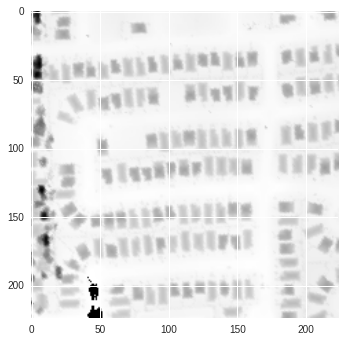

In [ ]:
depth_map, _,_,_ = get_data_batch_from_indices([random.randint(0, len(hcad))])
depth_map = depth_map.astype(np.int32)
plt.imshow(depth_map[0], cmap = 'gray')
import scipy.misc
scipy.misc.imsave('../visualization/depth_image.png', depth_map[0])

In [ ]:
########################################################################################
# Davi Frossard, 2016                                                                  #
# VGG16 implementation in TensorFlow                                                   #
# Details:                                                                             #
# http://www.cs.toronto.edu/~frossard/post/vgg16/                                      #
# Model from https://gist.github.com/ksimonyan/211839e770f7b538e2d8#file-readme-md     #
# Weights from Caffe converted using https://github.com/ethereon/caffe-tensorflow      #
########################################################################################
import tensorflow as tf
import numpy as np
from scipy.misc import imread, imresize
from imagenet_classes import class_names
tf.reset_default_graph()
wind_ph = tf.placeholder(tf.float32, [None, wind_data.shape[1] + hcad.shape[1]], name = 'wind_data_placeholder')
class vgg16:
    def __init__(self, imgs, wind, weights=None, sess=None):
        self.imgs = imgs
        self.convlayers()
        self.fc_layers()
        self.probs = tf.nn.softmax(self.fc3l)
        if weights is not None and sess is not None:
            self.load_weights(weights, sess)


    def convlayers(self):
        self.parameters = []

        # zero-mean input
        with tf.name_scope('preprocess') as scope:
            mean = tf.constant([123.68, 116.779, 103.939], dtype=tf.float32, shape=[1, 1, 1, 3], name='img_mean')
            images = self.imgs-mean

        # conv1_1
        with tf.name_scope('conv1_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 3, 64], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            self.bottom_conv  = kernel
            conv = tf.nn.conv2d(images, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv1_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv1_2
        with tf.name_scope('conv1_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 64, 64], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv1_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv1_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool1
        self.pool1 = tf.nn.max_pool(self.conv1_2,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool1')

        # conv2_1
        with tf.name_scope('conv2_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 64, 128], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.pool1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[128], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv2_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv2_2
        with tf.name_scope('conv2_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 128, 128], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv2_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[128], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv2_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool2
        self.pool2 = tf.nn.max_pool(self.conv2_2,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool2')

        # conv3_1
        with tf.name_scope('conv3_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 128, 256], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.pool2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv3_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv3_2
        with tf.name_scope('conv3_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 256], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv3_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv3_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv3_3
        with tf.name_scope('conv3_3') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 256], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv3_2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv3_3 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool3
        self.pool3 = tf.nn.max_pool(self.conv3_3,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool3')

        # conv4_1
        with tf.name_scope('conv4_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.pool3, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv4_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv4_2
        with tf.name_scope('conv4_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv4_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv4_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv4_3
        with tf.name_scope('conv4_3') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv4_2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv4_3 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool4
        self.pool4 = tf.nn.max_pool(self.conv4_3,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool4')

        # conv5_1
        with tf.name_scope('conv5_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.pool4, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv5_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv5_2
        with tf.name_scope('conv5_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv5_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv5_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv5_3
        with tf.name_scope('conv5_3') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv5_2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv5_3 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool5
        self.pool5 = tf.nn.max_pool(self.conv5_3,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool4')

    def fc_layers(self):
        # fc1
        with tf.name_scope('fc1') as scope:
            shape = int(np.prod(self.pool5.get_shape()[1:]))
            fc1w = tf.Variable(tf.truncated_normal([shape, 4096],
                                                         dtype=tf.float32,
                                                         stddev=1e-1), name='weights')
            fc1b = tf.Variable(tf.constant(1.0, shape=[4096], dtype=tf.float32),
                                 trainable=True, name='biases')
            pool5_flat = tf.reshape(self.pool5, [-1, shape])
            fc1l = tf.nn.bias_add(tf.matmul(pool5_flat, fc1w), fc1b)
            self.pool5_flat = pool5_flat
            self.fc1 = tf.nn.relu(fc1l)
            self.parameters += [fc1w, fc1b]

        # fc2
        with tf.name_scope('fc2') as scope:
            fc2w = tf.Variable(tf.truncated_normal([4096, 4096],
                                                         dtype=tf.float32,
                                                         stddev=1e-1), name='weights')
            fc2b = tf.Variable(tf.constant(1.0, shape=[4096], dtype=tf.float32),
                                 trainable=True, name='biases')
            fc2l = tf.nn.bias_add(tf.matmul(self.fc1, fc2w), fc2b)
            self.fc2 = tf.nn.relu(fc2l)
            self.parameters += [fc2w, fc2b]

        # fc3
        with tf.name_scope('fc3') as scope:
            fc3w = tf.Variable(tf.truncated_normal([4096, 1000],
                                                         dtype=tf.float32,
                                                         stddev=1e-1), name='weights')
            self.last_hidden_weight = fc3w
            fc3b = tf.Variable(tf.constant(1.0, shape=[1000], dtype=tf.float32),
                                 trainable=True, name='biases')
            self.last_hidden_bias = fc3b
            self.fc3l = tf.nn.bias_add(tf.matmul(self.fc2, fc3w), fc3b)
            self.parameters += [fc3w, fc3b]
        # regression
        with tf.name_scope('fc3_alt') as scope:
            self.regress_w = tf.Variable(tf.truncated_normal([4096, 2],
                                                         dtype=tf.float32,
                                                         stddev=1e-1), name='weights')
            self.regress_b = tf.Variable(tf.constant(1.0, shape=[2], dtype=tf.float32),
                                 trainable=True, name='biases')
            self.regress = tf.nn.bias_add(tf.matmul(self.fc2, self.regress_w), self.regress_b)
            
            self.parameters += [self.regress_w, self.regress_b]

    def load_weights(self, weight_file, sess):
        weights = np.load(weight_file)
        keys = sorted(weights.keys())
        for i, k in enumerate(keys):
            print i, k, np.shape(weights[k])
            sess.run(self.parameters[i].assign(weights[k]))
sess = tf.Session()
imgs = tf.placeholder(tf.float32, [None, 224, 224, 3])
vgg = vgg16(imgs, wind_ph, 'vgg16_weights.npz', sess)


img1 = imread('laska.png', mode='RGB')
img1 = imresize(img1, (224, 224))
print img1.shape
img1 = np.mean(img1, axis = 2)
img1 = np.stack([img1]*3, -1)
# plt.hist(img1.flatten())
# plt.show()
plt.imshow(img1/255)
plt.show()
prob = sess.run(vgg.probs, feed_dict={vgg.imgs: [img1]})[0]
# print "regress:  ", sess.run(vgg.regress, feed_dict={vgg.imgs: [img1]})[0]
preds = (np.argsort(prob)[::-1])[0:5]
for p in preds:
    print class_names[p], prob[p]

0 conv1_1_W (3, 3, 3, 64)


In [4]:
import sqlite3
import numpy as np
# conn = sqlite3.connect('vgg_activations.db')

import io

def adapt_array(arr):
    """
    http://stackoverflow.com/a/31312102/190597 (SoulNibbler)
    """
    out = io.BytesIO()
    np.save(out, arr)
    out.seek(0)
    return sqlite3.Binary(out.read())

def convert_array(text):
    out = io.BytesIO(text)
    out.seek(0)
    return np.load(out)


# Converts np.array to TEXT when inserting
sqlite3.register_adapter(np.ndarray, adapt_array)

# Converts TEXT to np.array when selecting
sqlite3.register_converter("array", convert_array)

x = np.arange(12).reshape(2,6)

con = sqlite3.connect("vgg_activations.db", detect_types=sqlite3.PARSE_DECLTYPES)
cur = con.cursor()
# cur.execute("create table test (hcad int, arr array)")
# With this setup, you can simply insert the NumPy array with no change in syntax:


In [91]:
from IPython.display import clear_output


batch_size = 100
all_activations = []
for i in range(int(len(meta)*0.999912691447), len(meta), batch_size):

    print float(i)/len(meta)
    print len(all_activations)
    if random.random() < .1:
        clear_output()
    start_index = i
    print i
    num_to_read = min(batch_size, len(meta)-i-1)
    X, _, batch_hcad_numbers, _ = get_data_batch_from_indices(list(range(i,min(i+batch_size, len(meta)-1)))) 
    batch_hcad_numbers = [int(x) for x in list(batch_hcad_numbers)]
    activations = sess.run(vgg.pool5_flat, 
                                   feed_dict={vgg.imgs: X
                                             })
    for j in range(len(activations)):
        cur.execute("INSERT INTO test VALUES (?, ?)", (batch_hcad_numbers[j], activations[j]))
    
    con.commit()


0.999912691447
0
870400


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:29: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [85]:
print len(meta)

870476


In [53]:
print zip(batch_hcad_numbers, list(activations))[0]

(21440000001, array([  0.        ,   7.89227915,   0.        , ...,   0.        ,
        18.15153885,   0.        ], dtype=float32))


In [5]:
try:
    con.close()
except:
    pass

con = sqlite3.connect("vgg_activations.db", detect_types=sqlite3.PARSE_DECLTYPES)
cur = con.cursor()


def get_vgg_activations(hcad_numbers):
    pass


    
    

In [7]:
import time
all_indices = list(range(len(meta)))

NameError: name 'meta' is not defined

In [9]:

t0 = time.time()
command = "select * from test where hcad in (" + ", ".join([str(i) for i in np.random.choice(hcad_numbers, 1500)]) + ") order by hcad"  
cur.execute(command)

# print(list(hcad_numbers)[:10])

# for i in range(10):
#     print cur.fetchone()
    
t1 = time.time()

total = t1-t0
print total

NameError: name 'hcad_numbers' is not defined

In [145]:
t0 = time.time()
X = get_data_batch_from_indices(numpy.random.choice(all_indices, 64))[0]
sess.run(vgg.pool5_flat, 
                                   feed_dict={vgg.imgs: X
                                             })
t1 = time.time()

total = t1-t0
print total

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:29: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


0.623461008072


In [154]:
con.close()